In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/food_review

/content/gdrive/My Drive/food_review


#<b>1.Importing Required Pakcages

In [4]:
#Still need to check about outliers
!pip install tabletext
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tabletext

import re
from tqdm import tqdm
from datetime import datetime
import pickle
from scipy.sparse import save_npz,load_npz

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import download,pos_tag,word_tokenize

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,plot_confusion_matrix,accuracy_score

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from scipy.sparse import hstack,coo_matrix

from imblearn.over_sampling import SMOTE

%matplotlib inline

download('wordnet')
download('punkt')
download('averaged_perceptron_tagger')

  Created wheel for tabletext: filename=tabletext-0.1-cp36-none-any.whl size=6023 sha256=472b697ab9e055b1524bd1220f0aebe119b5ce2c7f646737d06b1583c54f162f
  Stored in directory: /root/.cache/pip/wheels/63/15/d8/897b137f43975c4f5f49139be65fee6dbeab6a3f88c1838f66
Successfully built tabletext


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#<b>2.EDA

##<b>2.1 Loading Dataset 

In [ ]:
data = pd.read_csv('Reviews.csv')

In [ ]:
data.head()

Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]

In [ ]:
print("Data size : ",data.shape)

Data size :  (568454, 10)


##<b>2.2 Sampling Dataset

<h1>566k rows are too much for processing so we are sampling 100k values randomly from the dataset

In [ ]:
data = data.sample(n=100000)
print("Data size : ",data.shape)

Data size :  (100000, 10)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 528718 to 272941
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99997 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99997 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 8.4+ MB


In [ ]:
# data.drop(['Id'],inplace=True,axis=1)
# data.drop(['Time'],inplace=True,axis=1)

In [ ]:
print("Number of unique users : "+str(len(data['ProfileName'].unique())))

Number of unique users : 64680


In [ ]:
print("Number of unique products : "+str(len(data['ProductId'].unique())))

Number of unique products : 31580


##<b>2.3 Processing missing and duplicate values and outliers

###<b>2.3.1 Processing missing values and duplicate values

In [ ]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   3
Text                      0
dtype: int64

<h1>As we can see that missing values are very low in number compaired to our dataset so we can drop the rows containing missing values</h1>

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

###<b>2.3.2 Processing duplicate values

In [ ]:
data[data.duplicated(subset={"UserId","ProfileName","Time","Text"},keep=False)].sort_values(by=["UserId","ProfileName","Time","Text"])

Id  ...                                               Text
290997  290998  ...  By now, you're among the millions of people dr...
455583  455584  ...  By now, you're among the millions of people dr...
290914  290915  ...  Been buying this water for a couple of years. ...
496860  496861  ...  Been buying this water for a couple of years. ...
181246  181247  ...  First of all the way the K-cup is pakaged tend...
...        ...  ...                                                ...
88657    88658  ...  I like the peppered flavor a lot better than t...
380462  380463  ...  Our puppy loves this product, and we will cont...
205455  205456  ...  Our puppy loves this product, and we will cont...
181746  181747  ...  This particular brand and blend of Green Mount...
148483  148484  ...  This particular brand and blend of Green Mount...

[21169 rows x 10 columns]

<h1>We will drop these duplicate values from the dataset

In [ ]:
data_deduplicated = data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

<h2> % data remaining

In [ ]:
data_deduplicated.shape[0]/data.shape[0]

0.8758325499529972

In [ ]:
data = data_deduplicated

In [ ]:
# for conserving memory
del data_deduplicated

<h2> Cross checking if any dupliate data is remaining

In [ ]:
data[data.duplicated(subset={"UserId","ProfileName","Time","Text"},keep=False)]

Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []

###<b>2.3. Processing outliers

<h2> There are some rows where 'HelpfulnessNumerator' is greater than 'HelpfulnessDenominator' which is not possible so we will remove such rows

In [ ]:
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]

##<b>2.4 Setting the target variable

In [ ]:
target = data['Score']

<h1> Checking distribution of target variable in the dataset

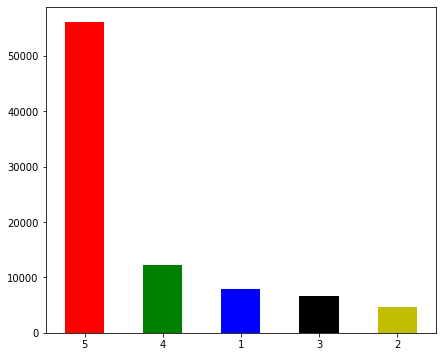

In [ ]:
target.value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

In [ ]:
target = target[target!=3]

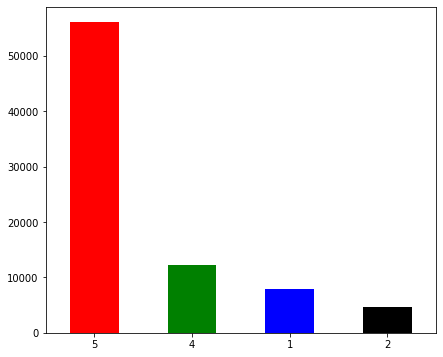

In [ ]:
target.value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

<h1>We will consider score of 1 & 2 as negative and 4,5 as positive and ignore rating 3 as it doesnt add any value to semtiment(more or less neutral reviews)

In [ ]:
target = target.apply(lambda x: 1 if x>3 else 0)

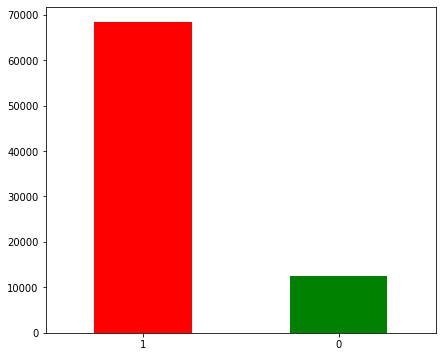

In [ ]:
target.value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

<h1>We can observe here that classes are highly imbalanced

In [ ]:
data = data[data['Score'] !=3 ]

In [ ]:
#replacing score with binary class in the dataset
data['Score'] = target

In [ ]:
data['ProfileName'].value_counts()

Rebecca of Amazon "The Rebecca Review"    58
C. F. Hill "CFH"                          55
Gary Peterson                             54
O. Brown "Ms. O. Khannah-Brown"           52
Chris                                     47
                                          ..
Kim L. Haines                              1
HomeCoder                                  1
J. Reisinger                               1
M. Gonzales "emelgee"                      1
V. Davis                                   1
Name: ProfileName, Length: 61069, dtype: int64

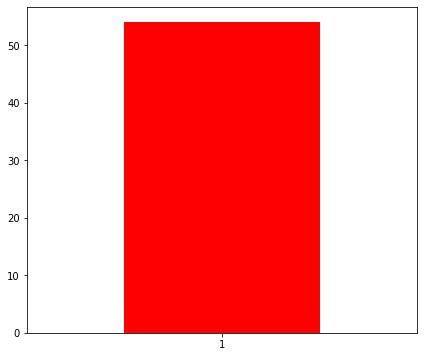

In [ ]:
# we will check what is the ratio of reviews of user having higest number of reviews
data.loc[data['ProfileName']=='Gary Peterson']['Score'].value_counts().plot(kind='bar',figsize=(7, 6), rot=0,color= list('rgbkymc'))

<h2>We can observe that this user has given positive reviews for all the orders so having profilename as a feature could add a lot of value to our prediction which we can target in future course of work.

#<b>2.5 Text Preprocessing

###<b>2.5.1 Creating list of Stopwords

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you'
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he'
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because'
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into'
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on',
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than'
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've"
've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn'
"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't"
'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
#utility function for cleaning the text 

def text_preprocessing(text):

  #Removing HTML tags
  #https://stackoverflow.com/a/12982689
  cleanr = re.compile('<.*?>')
  clean_text = re.sub(cleanr, '', text)
  
  #Removing abbreviations 
  # https://stackoverflow.com/a/47091490/4084039
  # specific
  clean_text = re.sub(r"won't", "will not", clean_text)
  clean_text = re.sub(r"can\'t", "can not", clean_text)
  # general
  clean_text = re.sub(r"n\'t", " not", clean_text)
  clean_text = re.sub(r"\'re", " are", clean_text)
  clean_text = re.sub(r"\'s", " is", clean_text)
  clean_text = re.sub(r"\'d", " would", clean_text)
  clean_text = re.sub(r"\'ll", " will", clean_text)
  clean_text = re.sub(r"\'t", " not", clean_text)
  clean_text = re.sub(r"\'ve", " have", clean_text)
  clean_text = re.sub(r"\'m", " am", clean_text)
  
  # \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-py
  clean_text = clean_text.replace('\\r', ' ')
  clean_text = clean_text.replace('\\"', ' ')
  clean_text = clean_text.replace('\\n', ' ')

  #remove spacial character: https://stackoverflow.com/a/5843547/4084039
  clean_text = re.sub('[^A-Za-z0-9]+', ' ', clean_text)
  
  #changing casing of all text to lower
  clean_text = " ".join([word.lower().strip() for word in clean_text.split()])

  #stop word removal : # https://gist.github.com/sebleier/554280
  clean_text = ' '.join([e for e in clean_text.split() if e.strip() not in stopwords])

  return clean_text

###<b>2.5.2 Preprocessing Summary

In [ ]:
data['PreprocessedSummary'] = data['Summary'].apply(text_preprocessing)
data.drop(['Summary'],axis=1,inplace=True)

###<b>2.5.3 Preprocessing Text

In [ ]:
data['PreprocessedText'] = data['Text'].apply(text_preprocessing)
data.drop(['Text'],axis=1,inplace=True)

###<b>2.5.4 Creating function for lemmatizing text data

In [ ]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = pos_tag(word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

###<b>2.5.5 Lemmatizing Summary

In [ ]:
data['PreprocessedSummary'] = data['PreprocessedSummary'].apply(lemmatize_sentence)

###<b>2.5.6 Lemmatizing Text

In [ ]:
data['PreprocessedText'] = data['PreprocessedText'].apply(lemmatize_sentence)

##<b>2.6 Creating Word Cloud 

###<b>2.6.1 Word Cloud of text data of the user with highest number of reviews

In [ ]:
#https://www.datacamp.com/community/tutorials/wordcloud-python

stopwords = set(STOPWORDS)
stopwords.remove("not")
stopwords.remove("no")
print("Number of stopwords : "+str(len(stopwords)))
print(stopwords)

Number of stopwords : 188
{'could', 'until', 'whom', 'that', 'here', 'from', 'doing', 'being', 'because', 'each', "he'd", 'and', 'on', "didn't", "haven't", 'so', 'their', "couldn't", 'same', "shan't", "you'd", 'such', 'with', 'before', 'above', 'them', "let's", 'is', 'why', "where's", 'own', 'itself', "when's", 'both', 'r', 'ours', 'he', 'his', 'can', 'do', 'for', 'more', 'to', 'your', 'did', 'shall', 'does', "shouldn't", 'http', 'cannot', 'com', 'after', 'ever', 'this', 'k', "they've", 'himself', 'had', "how's", "that's", "i'll", 'who', 'which', "can't", 'too', 'my', "there's", 'however', 'further', 'of', 'or', 'myself', 'she', "don't", "won't", 'but', 'off', 'only', 'under', 'herself', 'during', 'me', "she's", "they're", 'theirs', 'into', "he'll", 'where', "you've", "he's", 'else', "she'd", "they'll", 'in', 'most', "you'll", 'any', 'should', 'hers', 'over', 'below', 'www', "i'd", "we're", 'once', "we'll", 'as', 'him', 'than', 'all', "why's", 'out', 'few', 'am', "aren't", "wouldn't", 

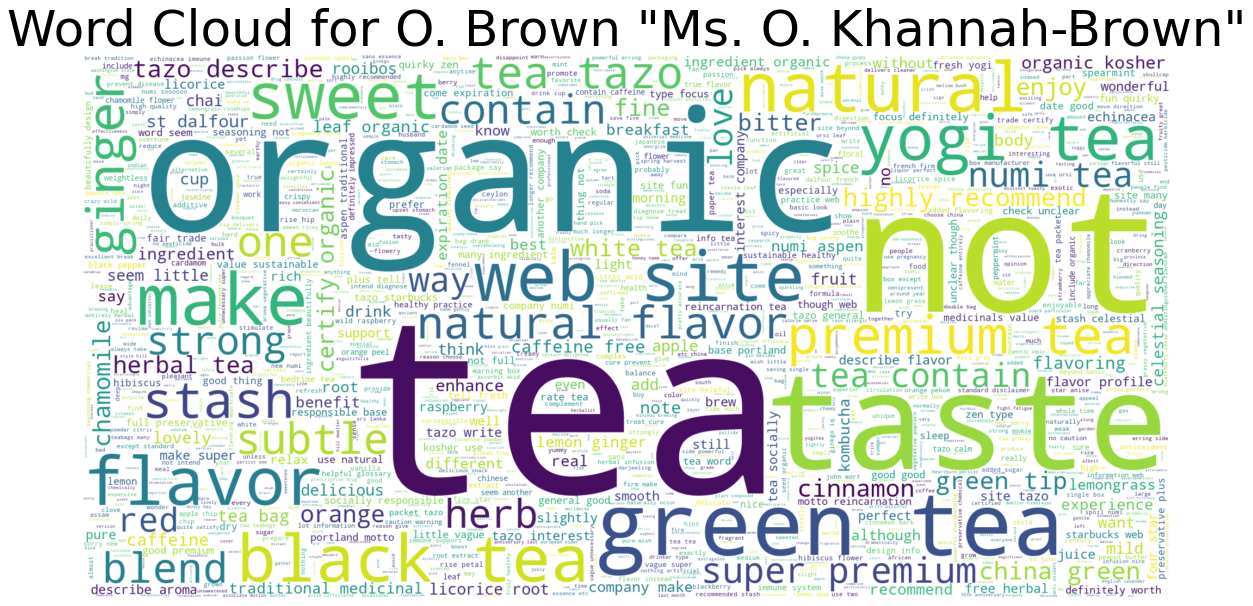

In [ ]:
text = " ".join(review for review in data.loc[data['ProfileName']=='O. Brown "Ms. O. Khannah-Brown"',['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for O. Brown "Ms. O. Khannah-Brown"',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.2 Word Cloud of Summary data of the user with highest number of reviews

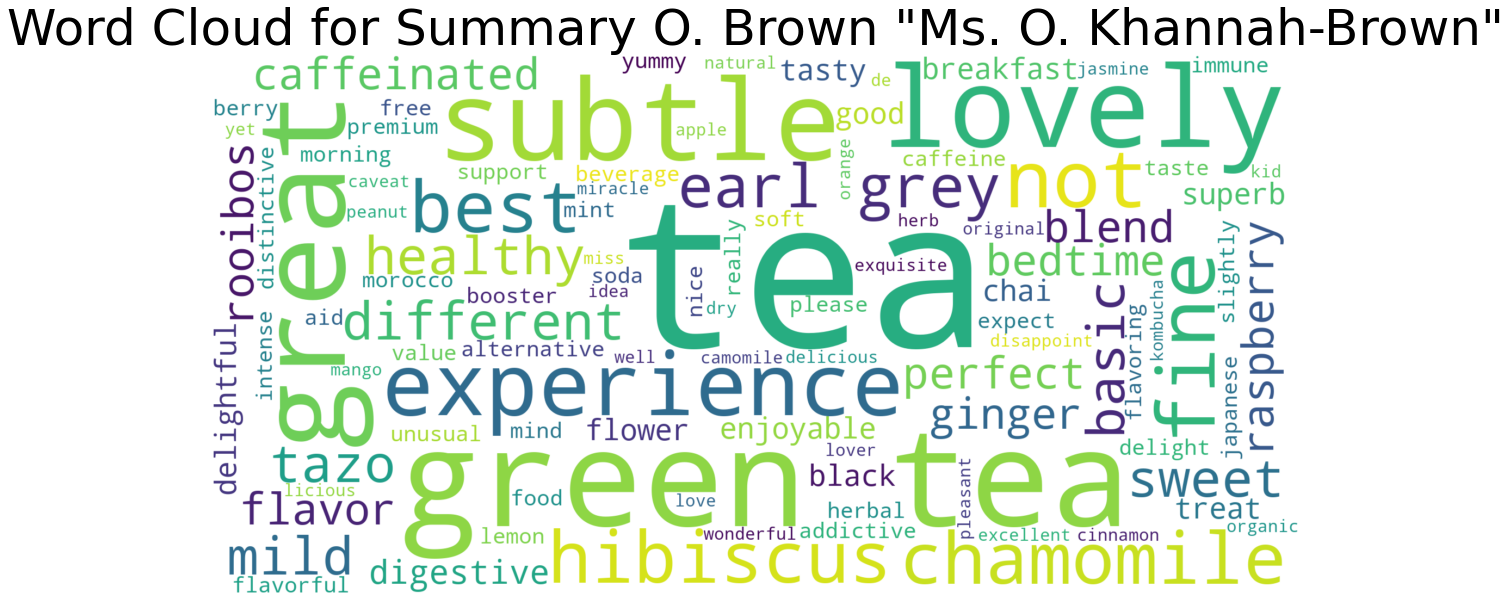

In [ ]:
text = " ".join(review for review in data.loc[data['ProfileName']=='O. Brown "Ms. O. Khannah-Brown"',['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ('Word Cloud for Summary of O. Brown "Ms. O. Khannah-Brown"')
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Summary O. Brown "Ms. O. Khannah-Brown"',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>We can observe that this user particularly orders lot of tea and organing bevarages.



###<b>2.6.3 Word Cloud of text data of the positive reviews

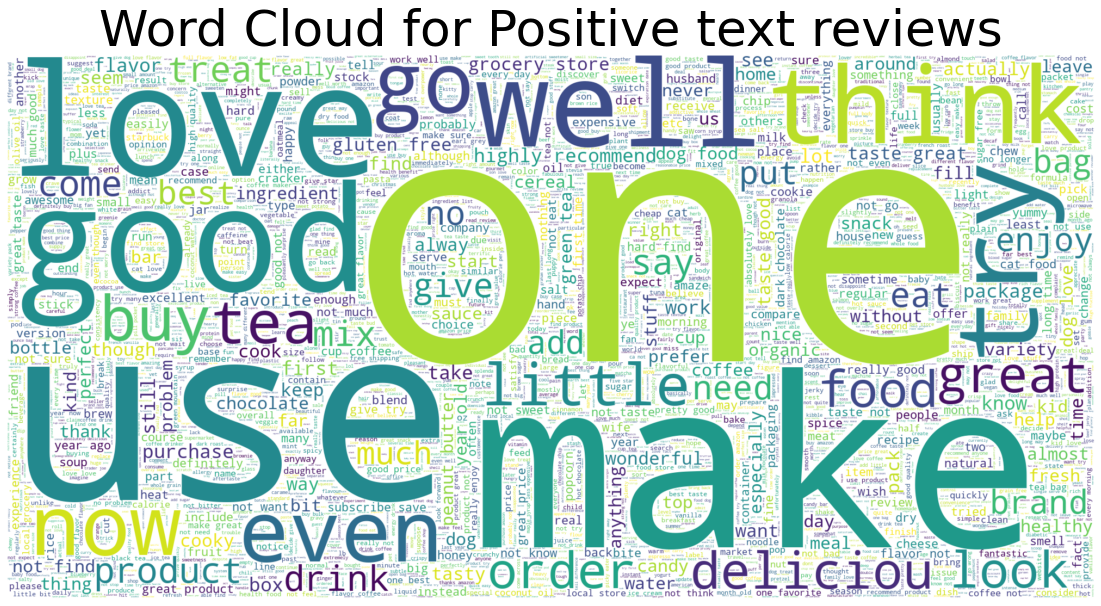

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==1,['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Positive Text")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Positive text reviews',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.4 Word Cloud of text data of the negative reviews

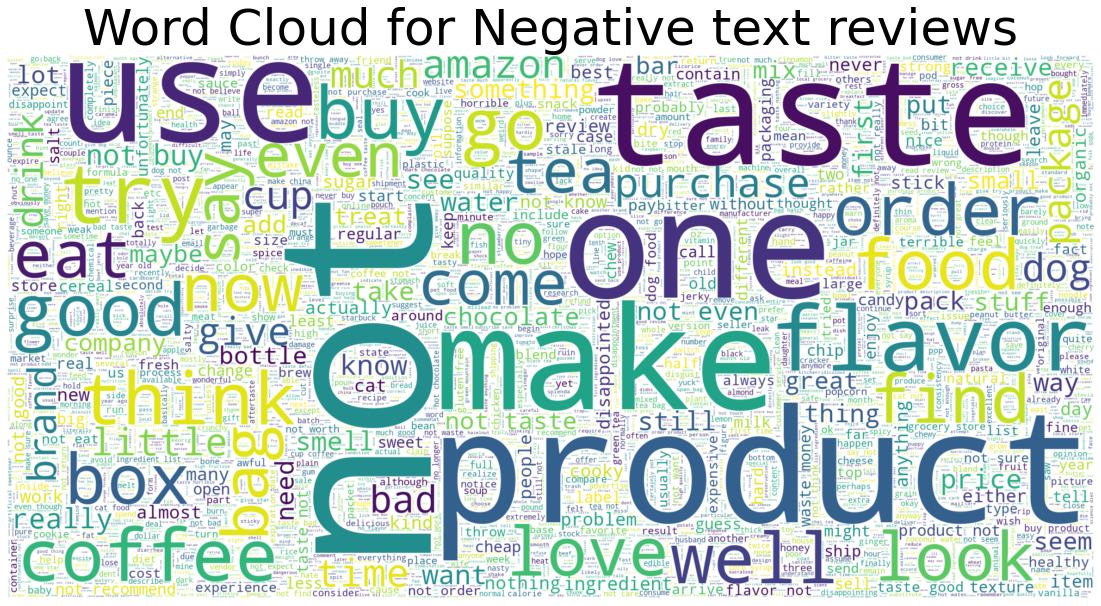

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==0,['PreprocessedText']].PreprocessedText)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Negative Text")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Negative text reviews',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.5 Word Cloud of Summary data of the positive reviews

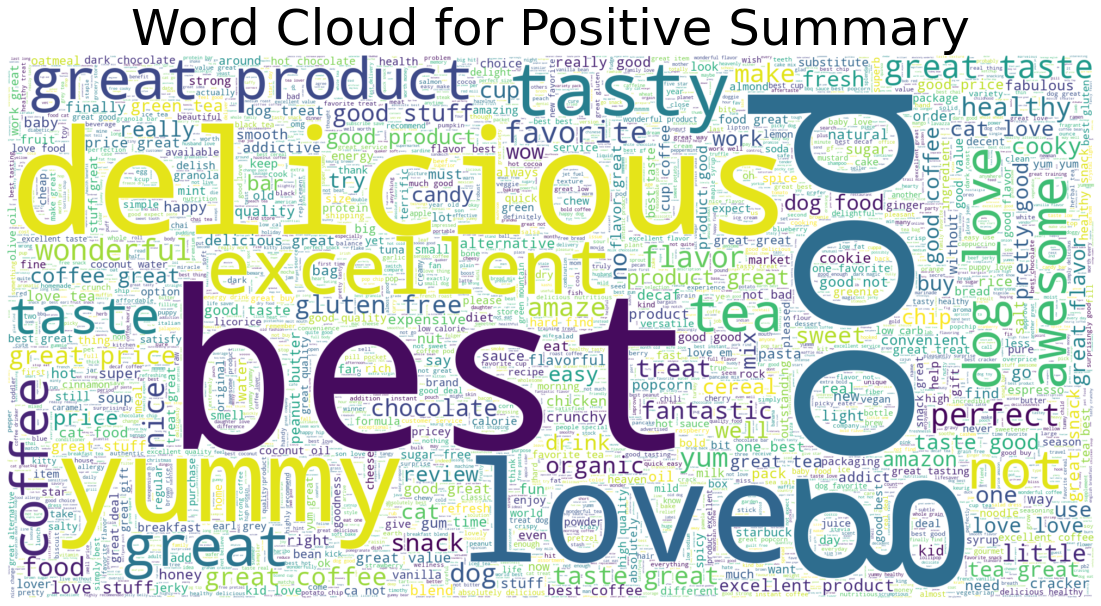

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==1,['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Positive Summary")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Positive Summary',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

###<b>2.6.6 Word Cloud of Summary data of the negative reviews

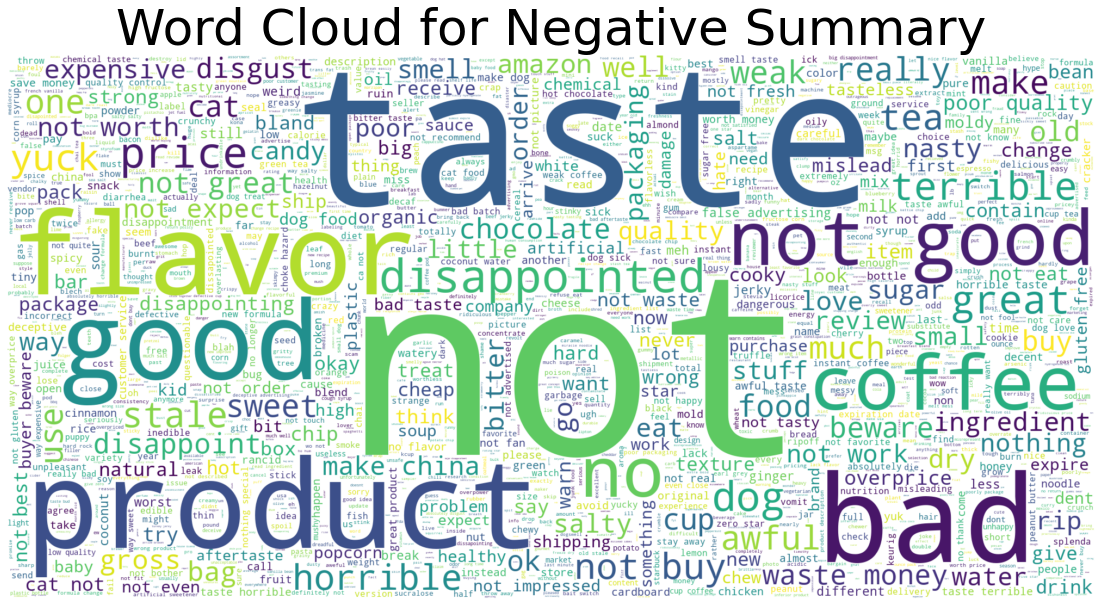

In [ ]:
text = " ".join(review for review in data.loc[data['Score']==0,['PreprocessedSummary']].PreprocessedSummary)
wc = WordCloud(background_color="white", max_words=len(text),width=2000, height=1000, stopwords=stopwords)
wc.generate(text)
# print ("Word Cloud for Negative Summary")
plt.figure( figsize=(20,10) )
plt.title('Word Cloud for Negative Summary',fontsize=50)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

##<b>2.7 Increasing weight of Summary

<h1> As we can see , Summary has more prominent words to divide the classess efectively so we will increase the weight of summary 

In [ ]:
def adding_summary_weight(text):
  return " ".join([text]*3)

In [ ]:
data['PreprocessedSummary'] = data['PreprocessedSummary'].apply(adding_summary_weight)

#<b> 3. Feature Engineering

##<b>3.1 Creating a new feature 'HelpfullnessRatio' as ratio of upvotes and downvotes of of a review

In [ ]:
data['HelpfulnessNumerator'].value_counts()

0      43290
1      16321
2       7613
3       4199
4       2506
       ...  
205        1
219        1
76         1
177        1
281        1
Name: HelpfulnessNumerator, Length: 130, dtype: int64

In [ ]:
data['HelpfulnessDenominator'].value_counts()

0      38823
1      15941
2       8692
3       4796
4       3200
       ...  
139        1
100        1
88         1
229        1
356        1
Name: HelpfulnessDenominator, Length: 136, dtype: int64

In [ ]:
ratios = []

for numerator,denominator in tqdm(zip(data['HelpfulnessNumerator'].values,data['HelpfulnessDenominator'].values)):
  if numerator!=0 and denominator!=0:
    ratios.append(numerator/denominator) 
  elif numerator == 0 and denominator!=0:
    ratios.append(-denominator)
  elif numerator!=0 and denominator == 0:
    ratios.append(numerator)
  else:
    ratios.append(0)

80935it [00:00, 352006.95it/s]


In [ ]:
data['HelpfullnessRatio'] = np.array(ratios)

In [ ]:
data['HelpfullnessRatio'].value_counts()

 0.000000    38823
 1.000000    26746
-1.000000     3022
 0.500000     2865
 0.666667     1397
             ...  
 0.606061        1
 0.677419        1
 0.877551        1
 0.895197        1
 0.580000        1
Name: HelpfullnessRatio, Length: 479, dtype: int64

##<b>3.2 Creating a new feature 'TextLength' as length of text of a review

In [ ]:
data['TextLength'] = data['PreprocessedText'].apply(len)

##<b>3.3 Creating a new feature 'SummaryLength' as length of summary of a review

In [ ]:
data['SummaryLength'] = data['PreprocessedSummary'].apply(len)

##<b>3.4 Plotting Correlation Matrix with numerical features

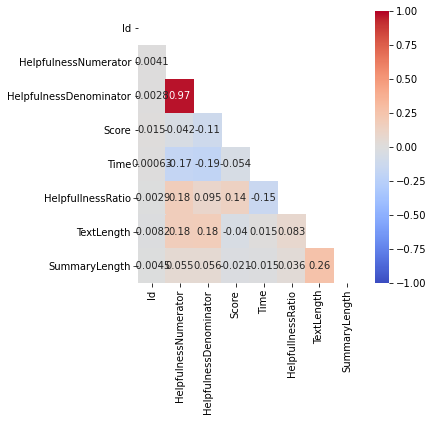

In [ ]:
#https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07

mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(),cmap='coolwarm',annot=True,fmt='.2g',vmin=-1,vmax=1, center= 0,mask = mask);

In [ ]:
data['HelpfulnessNumerator'].corr(data['HelpfulnessDenominator'])

0.970298523516907

<h1> As we can see there is high correlation among two features so we will drop one of them having lower correalation with target variable

In [ ]:
data.drop('HelpfulnessNumerator',axis=1,inplace=True)

#<b> 3. Feature Standardization and Vectorization

##<b> 3.1 Splitting the data

In [ ]:
data.drop(['Id','ProductId','UserId','ProfileName','Time','Score'],axis=1,inplace=True)

In [ ]:
Y = target.values
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.33, stratify=Y)

In [ ]:
print("shape of train features and target:",X_train.shape,Y_train.shape)
print("shape of test features and target:",X_test.shape,Y_test.shape)

shape of train features and target: (54226, 6) (54226,)
shape of test features and target: (26709, 6) (26709,)


##<b> 3.2 Standardizing numerical data

In [ ]:
numerical_scalar = StandardScaler()
numerical_scalar = numerical_scalar.fit(X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])

In [ ]:
X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']] = numerical_scalar.transform(X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])
X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']] = numerical_scalar.transform(X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
X_train.columns

Index(['HelpfulnessDenominator', 'PreprocessedSummary', 'PreprocessedText',
       'HelpfullnessRatio', 'TextLength', 'SummaryLength'],
      dtype='object')

In [ ]:
coulumn_list_bow = ['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']
coulumn_list_tfidf = ['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']

In [ ]:
X_train.head()

HelpfulnessDenominator  ... SummaryLength
507787               -0.155968  ...     -0.058033
445218               -0.017024  ...     -0.798222
255548               -0.017024  ...      0.219537
126338               -0.155968  ...      0.589632
47041                -0.155968  ...      0.774679

[5 rows x 6 columns]

##<b> 3.3 Vectorizing text and summary features

###<b> 3.3.1 Vectorizing using BOW

In [ ]:
summary_vectorizer_ohe = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

summary_vectorizer_ohe = summary_vectorizer_ohe.fit(X_train['PreprocessedSummary'].values)

X_train_PreprocessedSummary_ohe = summary_vectorizer_ohe.transform(X_train['PreprocessedSummary'].values)
X_test_PreprocessedSummary_ohe = summary_vectorizer_ohe.transform(X_test['PreprocessedSummary'].values)

coulumn_list_bow.extend(summary_vectorizer_ohe.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedSummary_ohe.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedSummary_ohe.shape)

Shape of train summary after vectorization :  (54226, 3500)
Shape of test summary after vectorization :  (26709, 3500)


<b><h2>High frequency words

In [ ]:
freqs = zip(summary_vectorizer_ohe.get_feature_names(), X_train_PreprocessedSummary_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 21855),
 ('good', 15399),
 ('love', 11232),
 ('not', 10836),
 ('best', 10329),
 ('taste', 8031),
 ('coffee', 7062),
 ('tea', 6555),
 ('product', 6411),
 ('delicious', 5973)]

In [ ]:
freqs = zip(summary_vectorizer_ohe.get_feature_names(), X_test_PreprocessedSummary_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 10803),
 ('good', 7401),
 ('love', 5523),
 ('not', 5502),
 ('best', 5085),
 ('taste', 3975),
 ('coffee', 3612),
 ('product', 3099),
 ('of', 3021),
 ('tea', 2997)]

In [ ]:
text_vectorizer_ohe = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

text_vectorizer_ohe = text_vectorizer_ohe.fit(X_train['PreprocessedText'].values)

X_train_PreprocessedText_ohe = text_vectorizer_ohe.transform(X_train['PreprocessedText'].values)
X_test_PreprocessedText_ohe = text_vectorizer_ohe.transform(X_test['PreprocessedText'].values)

coulumn_list_bow.extend(text_vectorizer_ohe.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedText_ohe.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedText_ohe.shape)

<b><h2>High frequency words

In [ ]:
freqs = zip(text_vectorizer_ohe.get_feature_names(), X_train_PreprocessedText_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 74383),
 ('not', 58076),
 ('that', 41200),
 ('you', 35080),
 ('they', 29147),
 ('have', 26261),
 ('like', 25885),
 ('as', 25640),
 ('taste', 23922),
 ('do', 23126),
 ('these', 22109),
 ('good', 22089),
 ('them', 19791),
 ('flavor', 18557),
 ('one', 18055),
 ('love', 17578),
 ('product', 17374),
 ('get', 17237),
 ('at', 16993),
 ('make', 16978)]

In [ ]:
freqs = zip(text_vectorizer_ohe.get_feature_names(), X_test_PreprocessedText_ohe.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 36607),
 ('not', 28564),
 ('that', 20564),
 ('you', 17627),
 ('they', 14285),
 ('have', 13206),
 ('as', 12884),
 ('like', 12833),
 ('taste', 11734),
 ('do', 11432),
 ('these', 10905),
 ('good', 10705),
 ('them', 9729),
 ('flavor', 9149),
 ('one', 8768),
 ('love', 8760),
 ('product', 8602),
 ('at', 8581),
 ('get', 8421),
 ('make', 8415)]

###<b> 3.3.2 Vectorizing using tfidf

In [ ]:
summary_vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

summary_vectorizer_tfidf = summary_vectorizer_tfidf.fit(X_train['PreprocessedSummary'].values)

X_train_PreprocessedSummary_tfidf = summary_vectorizer_tfidf.transform(X_train['PreprocessedSummary'].values)
X_test_PreprocessedSummary_tfidf = summary_vectorizer_tfidf.transform(X_test['PreprocessedSummary'].values)

coulumn_list_tfidf.extend(summary_vectorizer_tfidf.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedSummary_tfidf.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedSummary_tfidf.shape)

Shape of train summary after vectorization :  (54226, 3500)
Shape of test summary after vectorization :  (26709, 3500)


<b><h2>High frequency words

In [ ]:
freqs = zip(summary_vectorizer_tfidf.get_feature_names(), X_train_PreprocessedSummary_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 2012.1183765790895),
 ('good', 1472.8053899309098),
 ('love', 1354.434072955719),
 ('best', 1062.2129282598091),
 ('delicious', 1025.7866189568356),
 ('not', 948.5899794222523),
 ('taste', 832.7044438164729),
 ('product', 791.9155458782303),
 ('coffee', 785.1893129556057),
 ('tea', 750.2067459169954)]

In [ ]:
freqs = zip(summary_vectorizer_tfidf.get_feature_names(), X_test_PreprocessedSummary_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:10]

[('great', 985.3998149854708),
 ('good', 729.5182417761613),
 ('love', 669.5262464390663),
 ('best', 523.8932157760886),
 ('delicious', 511.69180388601006),
 ('not', 482.6358839829091),
 ('coffee', 409.6278530409688),
 ('taste', 409.4092352787689),
 ('product', 389.86042300363187),
 ('tea', 343.31503236163405)]

In [ ]:
text_vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)

text_vectorizer_tfidf = text_vectorizer_tfidf.fit(X_train['PreprocessedText'].values)

X_train_PreprocessedText_tfidf = text_vectorizer_tfidf.transform(X_train['PreprocessedText'].values)
X_test_PreprocessedText_tfidf = text_vectorizer_tfidf.transform(X_test['PreprocessedText'].values)

coulumn_list_tfidf.extend(text_vectorizer_tfidf.get_feature_names())

print("Shape of train summary after vectorization : ",X_train_PreprocessedText_tfidf.shape)
print("Shape of test summary after vectorization : ",X_test_PreprocessedText_tfidf.shape)

Shape of train summary after vectorization :  (54226, 5000)
Shape of test summary after vectorization :  (26709, 5000)


<b><h2>High frequency words

In [ ]:
freqs = zip(text_vectorizer_tfidf.get_feature_names(), X_train_PreprocessedText_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 2468.3648742483624),
 ('not', 2167.823623739339),
 ('you', 1668.4466443500926),
 ('that', 1648.8373021276898),
 ('they', 1555.3478367069285),
 ('these', 1371.8570894276097),
 ('taste', 1356.9865852778248),
 ('like', 1330.2053714913923),
 ('as', 1328.6375486364648),
 ('good', 1303.83781709667),
 ('have', 1296.754443644194),
 ('coffee', 1256.8421910922887),
 ('them', 1245.9111738334832),
 ('great', 1227.0316446829218),
 ('love', 1222.3754513470749),
 ('do', 1160.8175418652768),
 ('product', 1158.0894001069369),
 ('flavor', 1148.3629306016537),
 ('tea', 1117.1660788030251),
 ('very', 1061.8683280236326)]

In [ ]:
freqs = zip(text_vectorizer_tfidf.get_feature_names(), X_test_PreprocessedText_tfidf.sum(axis=0).tolist()[0])
sorted(freqs, key=lambda x: -x[1])[:20]

[('of', 1209.8017560241474),
 ('not', 1068.8736024083985),
 ('you', 832.4730243598349),
 ('that', 820.7038133437142),
 ('they', 757.999094895556),
 ('these', 677.1204617631107),
 ('taste', 662.9529288247824),
 ('as', 657.9019429524902),
 ('like', 656.9142057250924),
 ('have', 655.9966404148844),
 ('good', 629.5734632592385),
 ('them', 613.5337865178601),
 ('love', 608.3488714107577),
 ('coffee', 604.197214041876),
 ('great', 602.0958056579236),
 ('do', 575.8560754739323),
 ('product', 570.0905319618425),
 ('flavor', 559.2330696605376),
 ('tea', 558.0528495464839),
 ('very', 520.4126676757539)]

###<b> 3.3.3 Vectorizing using word2vec

In [ ]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
  print ("Loading Glove Model")
  f = open(gloveFile,'r', encoding="utf8")
  model = {}
  for line in tqdm(f):
    splitLine = line.split()
    word = splitLine[0]
    embedding = np.array([float(val) for val in splitLine[1:]])
    model[word] = embedding
  print ("Done.",len(model)," words loaded!")
  return model

model = loadGloveModel('glove.42B.300d.txt')
glove_words = set(model.keys())

Loading Glove Model


1917495it [03:40, 8705.25it/s]


Done. 1917495  words loaded!


In [ ]:
x_train_summary_avg_w2v = []

for sentence in tqdm(X_train['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_train_summary_avg_w2v.append(w2v)

x_train_summary_avg_w2v = np.array(x_train_summary_avg_w2v)

100%|██████████| 54226/54226 [00:01<00:00, 38008.64it/s]


In [ ]:
x_test_summary_avg_w2v = []

for sentence in tqdm(X_test['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_test_summary_avg_w2v.append(w2v)

x_test_summary_avg_w2v = np.array(x_test_summary_avg_w2v)

100%|██████████| 26709/26709 [00:00<00:00, 37654.90it/s]


In [ ]:
x_train_text_avg_w2v = []

for sentence in tqdm(X_train['PreprocessedText'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_train_text_avg_w2v.append(w2v)

x_train_text_avg_w2v = np.array(x_train_text_avg_w2v)

100%|██████████| 54226/54226 [00:08<00:00, 6622.76it/s]


In [ ]:
x_test_text_avg_w2v = []

for sentence in tqdm(X_test['PreprocessedText'].values):
  w2v = np.zeros(300)
  count = 0

  for word in sentence.split():
    if word in glove_words:
      w2v += model[word]
      count += 1
  if count !=0 :
    w2v /= count

  x_test_text_avg_w2v.append(w2v)

x_test_text_avg_w2v = np.array(x_test_text_avg_w2v)

100%|██████████| 26709/26709 [00:04<00:00, 6549.69it/s]


###<b> 3.3.1 Vectorizing using tfidf-word2vec

In [ ]:
tfidf_summary = TfidfVectorizer(ngram_range=(1,1))
tfidf_summary = tfidf_summary.fit(X_train['PreprocessedSummary'].values)

tfdf_summary_dict = dict(zip(tfidf_summary.get_feature_names(),list(tfidf_summary.idf_)))
tfidf_summary_words = tfidf_summary.get_feature_names()

In [ ]:
x_train_summary_tfidf_w2v = []

for sentence in tqdm(X_train['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_summary_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_summary_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_train_summary_tfidf_w2v.append(w2v)

x_train_summary_tfidf_w2v = np.array(x_train_summary_tfidf_w2v)

100%|██████████| 54226/54226 [00:49<00:00, 1085.70it/s]


In [ ]:
x_test_summary_tfidf_w2v = []

for sentence in tqdm(X_test['PreprocessedSummary'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_summary_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_summary_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_test_summary_tfidf_w2v.append(w2v)

x_test_summary_tfidf_w2v = np.array(x_test_summary_tfidf_w2v)

100%|██████████| 26709/26709 [00:25<00:00, 1060.69it/s]


In [ ]:
tfidf_text = TfidfVectorizer()
tfidf_text = tfidf_text.fit(X_train['PreprocessedText'].values)

tfdf_text_dict = dict(zip(tfidf_text.get_feature_names(),list(tfidf_text.idf_)))
tfidf_text_words = tfidf_text.get_feature_names()

In [ ]:
x_train_text_tfidf_w2v = []

for sentence in tqdm(X_train['PreprocessedText'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_text_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_text_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_train_text_tfidf_w2v.append(w2v)

x_train_text_tfidf_w2v = np.array(x_train_text_tfidf_w2v)

100%|██████████| 54226/54226 [20:59<00:00, 43.05it/s]


In [ ]:
x_test_text_tfidf_w2v = []

for sentence in tqdm(X_test['PreprocessedText'].values):
  w2v = np.zeros(300)
  tfidf_weight = 0

  for word in sentence.split():
    if word in glove_words and word in tfidf_text_words:
      w2v += model[word]
      count += 1
      tfidf = sentence.count(word)/len(sentence.split()) * tfdf_text_dict[word]
      w2v *= tfidf
      tfidf_weight += tfidf
  if tfidf_weight !=0 :
    w2v /= tfidf_weight

  x_test_text_tfidf_w2v.append(w2v)

x_test_text_tfidf_w2v = np.array(x_test_text_tfidf_w2v)

100%|██████████| 26709/26709 [10:04<00:00, 44.22it/s]


In [ ]:
# For conserving memory
del model
del tfidf_summary
del tfdf_summary_dict
del tfidf_summary_words
del tfidf_text
del tfdf_text_dict
del tfidf_text_words
del w2v

<h1> Dumping all the vectors

In [ ]:
X_train.to_pickle("X_train.pkl")
X_test.to_pickle("X_test.pkl")
Y_train.dump("Y_train.pkl")
Y_test.dump("Y_test.pkl")

In [25]:
coulumn_list_bow = np.array(coulumn_list_bow)
coulumn_list_tfidf = np.array(coulumn_list_tfidf)

coulumn_list_bow.dump("coulumn_list_bow.pkl")
coulumn_list_tfidf.dump("coulumn_list_tfidf.pkl")

In [ ]:
save_npz("X_train_PreprocessedSummary_ohe.npz",X_train_PreprocessedSummary_ohe)
save_npz("X_test_PreprocessedSummary_ohe.npz",X_test_PreprocessedSummary_ohe)
save_npz("X_train_PreprocessedText_ohe.npz",X_train_PreprocessedText_ohe)
save_npz("X_test_PreprocessedText_ohe.npz",X_test_PreprocessedText_ohe)

In [ ]:
save_npz( "X_train_PreprocessedSummary_tfidf.npz",X_train_PreprocessedSummary_tfidf)
save_npz( "X_test_PreprocessedSummary_tfidf.npz", X_test_PreprocessedSummary_tfidf)
save_npz( "X_train_PreprocessedText_tfidf.npz",X_train_PreprocessedText_tfidf)
save_npz( "X_test_PreprocessedText_tfidf.npz", X_test_PreprocessedText_tfidf)

In [ ]:
x_train_summary_avg_w2v.dump("X_train_summary_avg_w2v.pkl")
x_test_summary_avg_w2v.dump("X_test_summary_avg_w2v.pkl")
x_train_text_avg_w2v.dump("X_train_text_avg_w2v.pkl")
x_test_text_avg_w2v.dump("X_test_text_avg_w2v.pkl")

In [ ]:
x_train_summary_tfidf_w2v.dump("X_train_summary_tfidf_w2v.pkl")
x_test_summary_tfidf_w2v.dump("X_test_summary_tfidf_w2v.pkl")
x_train_text_tfidf_w2v.dump("X_train_text_tfidf_w2v.pkl")
x_test_text_tfidf_w2v.dump("X_test_text_tfidf_w2v.pkl")

<h1> Loading all the vectors

In [5]:
X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")

Y_train = np.load("Y_train.pkl", allow_pickle=True)
Y_test = np.load("Y_test.pkl", allow_pickle=True)

In [26]:
coulumn_list_bow = np.load("coulumn_list_bow.pkl", allow_pickle=True)
coulumn_list_tfidf = np.load("coulumn_list_tfidf.pkl", allow_pickle=True)

coulumn_list_bow = list(coulumn_list_bow)
coulumn_list_tfidf = list(coulumn_list_tfidf)

In [9]:
X_train_PreprocessedSummary_ohe = load_npz("X_train_PreprocessedSummary_ohe.npz")
X_test_PreprocessedSummary_ohe = load_npz("X_test_PreprocessedSummary_ohe.npz")
X_train_PreprocessedText_ohe = load_npz("X_train_PreprocessedText_ohe.npz")
X_test_PreprocessedText_ohe = load_npz("X_test_PreprocessedText_ohe.npz")

In [10]:
X_train_PreprocessedSummary_tfidf = load_npz("X_train_PreprocessedSummary_tfidf.npz")
X_test_PreprocessedSummary_tfidf = load_npz("X_test_PreprocessedSummary_tfidf.npz")
X_train_PreprocessedText_tfidf = load_npz("X_train_PreprocessedText_tfidf.npz")
X_test_PreprocessedText_tfidf = load_npz("X_test_PreprocessedText_tfidf.npz")

In [11]:
x_train_summary_avg_w2v = np.load("X_train_summary_avg_w2v.pkl",allow_pickle=True)
x_test_summary_avg_w2v = np.load("X_test_summary_avg_w2v.pkl",allow_pickle=True)
x_train_text_avg_w2v = np.load("X_train_text_avg_w2v.pkl",allow_pickle=True)
x_test_text_avg_w2v = np.load("X_test_text_avg_w2v.pkl",allow_pickle=True)

In [12]:
x_train_summary_tfidf_w2v = np.load("X_train_summary_tfidf_w2v.pkl",allow_pickle=True)
x_test_summary_tfidf_w2v = np.load("X_test_summary_tfidf_w2v.pkl",allow_pickle=True)
x_train_text_tfidf_w2v = np.load("X_train_text_tfidf_w2v.pkl",allow_pickle=True)
x_test_text_tfidf_w2v = np.load("X_test_text_tfidf_w2v.pkl",allow_pickle=True)

#<b> 4. Applying Machine Learning Model

##<b>4.1 Merging all the data

###<b> 4.1.1 BOW

In [13]:
x_train_bow = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_train_PreprocessedSummary_ohe,X_train_PreprocessedText_ohe)).tocsr()
x_test_bow = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_test_PreprocessedSummary_ohe,X_test_PreprocessedText_ohe)).tocsr()

In [14]:
x_train_tfidf = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_train_PreprocessedSummary_tfidf,X_train_PreprocessedText_tfidf)).tocsr()
x_test_tfidf = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,X_test_PreprocessedSummary_tfidf,X_test_PreprocessedText_tfidf)).tocsr()

In [15]:
x_train_avg_w2v = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_train_summary_avg_w2v),coo_matrix(x_train_text_avg_w2v))).tocsr()
x_test_avg_w2v = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_test_summary_avg_w2v),coo_matrix(x_test_text_avg_w2v))).tocsr()

In [16]:
x_train_tfidf_w2v = hstack((X_train[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_train_summary_tfidf_w2v),coo_matrix(x_train_text_tfidf_w2v))).tocsr()
x_test_tfidf_w2v = hstack((X_test[['HelpfulnessDenominator','HelpfullnessRatio', 'TextLength', 'SummaryLength']].values,coo_matrix(x_test_summary_tfidf_w2v),coo_matrix(x_test_text_tfidf_w2v))).tocsr()

##<b>4.2 Logistic Regression

In [28]:
def print_plot_metrics(classifier,x_train,x_test,y_true_train,y_predicted_train,y_true_test,y_predicted_test):
  
  data = [['dataset','Precision','Recall','F1_Score','Accuracy'],
  ['Train',precision_score(y_true_train,y_predicted_train),recall_score(y_true_train,y_predicted_train),f1_score(y_true_train,y_predicted_train),accuracy_score(y_true_train,y_predicted_train)],
  ['Test',precision_score(y_true_test,y_predicted_test),recall_score(y_true_test,y_predicted_test),f1_score(y_true_test,y_predicted_test),accuracy_score(y_true_test,y_predicted_test)],
  ]
  print(tabletext.to_text(data))

  plot_confusion_matrix(classifier,x_train,y_true_train)
  plt.title("Train Confusion Matrix",fontsize=30)
  plt.show()
  plot_confusion_matrix(classifier,x_test,y_true_test)
  plt.title("Test Confusion Matrix",fontsize=30)
  plt.show()
  

###<b>4.2.1 Using BOW

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   55.5s finished


Score from Best params :  0.9601203942955654
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:01:48.253926


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9999121689868693 │ 0.9941492380910798 │ 0.9970223759688227 │   0.99498395603585 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9620550556318985 │ 0.9619271341193156 │ 0.9619910906229914 │ 0.9357894342730915 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


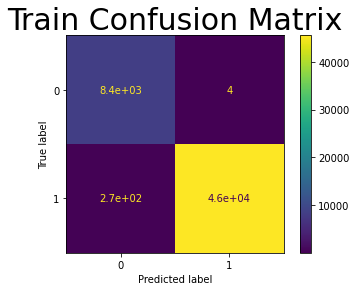

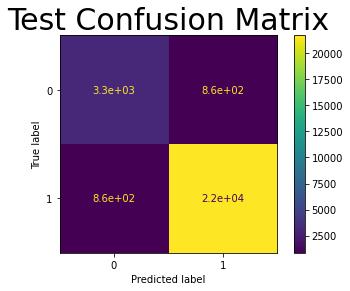

In [75]:
classifier = SGDClassifier(penalty='l1', loss='log',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

print_plot_metrics(classifier,x_train_bow,x_test_bow,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

<b><h1> Feature importance :

In [76]:
feature_imp_value_list = list(zip(coulumn_list_bow,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('december', -2813.671346113943),
 ('not worth', -1200.2500879239703),
 ('yum', 1179.2708276704298),
 ('fantastic', 1157.237733438637),
 ('disappointing', -1091.2616979459724),
 ('2012', -1039.045468472309),
 ('not bad', 1026.4169074103156),
 ('disappointment', -1013.6045747797077),
 ('ruin', -977.2358504582504),
 ('not recommend', -955.7445941077103),
 ('awesome', 932.8404486954398),
 ('yuck', -924.6390391927623),
 ('terrible', -902.3709224643693),
 ('excellent', 845.2673936769726),
 ('not very', -839.8755780593153),
 ('amaze', 836.616261033958),
 ('finally', 834.4313144014858),
 ('tasteless', -819.3759691331848),
 ('disappointment', -811.254816761949),
 ('not very', -804.8961130740805),
 ('disappointing', -773.0642527588911),
 ('not too', 751.3486748611263),
 ('not order', -749.9199298015657),
 ('lack', -730.533708032319),
 ('amaze', 726.5571006302016)]

###<b>4.2.2 Using TFIDF 

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.3s finished


Score from Best params :  0.9635491033426509
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:21.389084


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9992469045562274 │ 0.9848709776011876 │ 0.9920068606862885 │ 0.9865931471987608 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9677405001334876 │ 0.9639659604644978 │ 0.9658495425881517 │ 0.9424164139428657 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


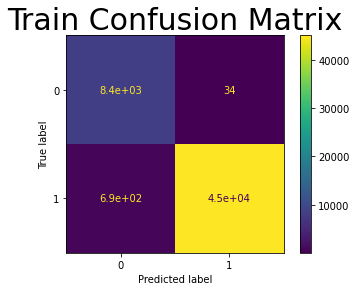

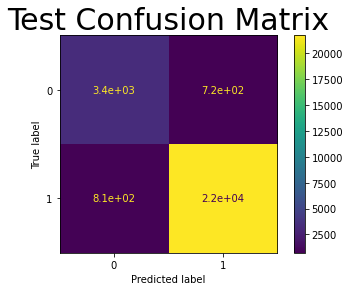

In [81]:
classifier = SGDClassifier(penalty='l1', loss='log',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

print_plot_metrics(classifier,x_train_tfidf,x_test_tfidf,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

<b><h1> Feature importance :

In [82]:
feature_imp_value_list = list(zip(coulumn_list_tfidf,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('excellent', 287.02470071661156),
 ('disappointing', -286.4071923924484),
 ('fantastic', 265.350865667609),
 ('excellent', 264.7900727821673),
 ('great', 248.9894237628012),
 ('delicious', 244.9092194400126),
 ('disappointing', -239.77808393281663),
 ('not too', 228.6507530409156),
 ('awesome', 226.31404720742023),
 ('horrible', -226.23258689570108),
 ('not buy', -224.3209024873067),
 ('terrible', -222.4371831380587),
 ('perfect', 219.36319676325766),
 ('disappointment', -219.1258081548192),
 ('not recommend', -210.31849497211297),
 ('yum', 205.75508132068904),
 ('disgust', -204.72413865273836),
 ('best', 204.69319333680644),
 ('not worth', -195.78239056579153),
 ('ruin', -194.73685255149013),
 ('nasty', -192.30452613634216),
 ('amaze', 192.2686207702093),
 ('ruin', -192.20107769960984),
 ('not very', -189.49321342850558),
 ('amaze', 189.17044993475412)]

###<b>4.2.3 Using Avg-W2Vec

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.8min finished


Score from Best params :  0.9282934048668444
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:54.659103


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9879168320762207 │ 0.8692529362965551 │ 0.9247938683079782 │ 0.8805738944417807 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9877476932385418 │ 0.8682740891764914 │ 0.9241655855643353 │ 0.8796285896139878 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


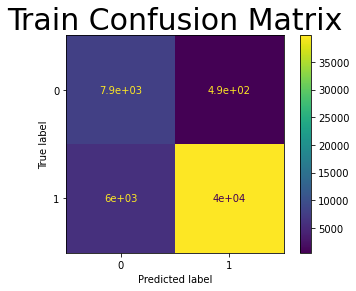

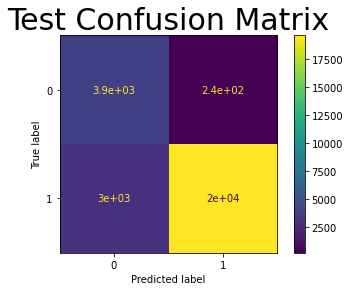

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='log',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

print_plot_metrics(classifier,x_train_avg_w2v,x_test_avg_w2v,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

##<b>4.3 SVM

###<b>4.3.1 Using BOW

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(penalty='l1', loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   47.4s finished


Score from Best params :  0.9602055903877877
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:01:43.021719


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9998242762377543 │  0.993712614068026 │ 0.9967590767748434 │ 0.9945413639213662 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │  0.962072483697822 │ 0.9612622994415388 │ 0.9616672209289435 │ 0.9352652663896065 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


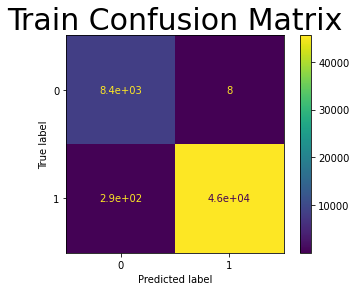

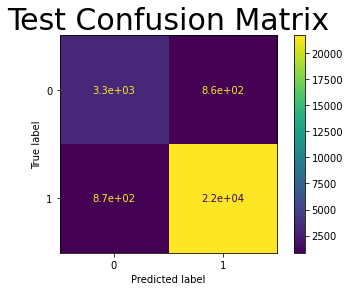

In [77]:
classifier = SGDClassifier(penalty='l1', loss='hinge',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

print_plot_metrics(classifier,x_train_bow,x_test_bow,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

<b><h1> Feature importance :

In [78]:
feature_imp_value_list = list(zip(coulumn_list_bow,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('december', -2863.2566413042996),
 ('not worth', -1179.6229368858455),
 ('disappointing', -1145.1786853342276),
 ('fantastic', 1103.8063430493075),
 ('yum', 1021.4113519806054),
 ('not bad', 1010.4513118269457),
 ('not recommend', -1000.2825806421802),
 ('2012', -999.1463522268833),
 ('awesome', 979.9139768851105),
 ('disappointment', -880.2418391203719),
 ('amaze', 869.8748565024707),
 ('excellent', 856.2688237121819),
 ('ruin', -842.5527475072684),
 ('terrible', -830.9795775590055),
 ('disappointing', -821.5493386274975),
 ('not too', 817.5309750537424),
 ('amaze', 813.2262757949768),
 ('disappointment', -802.0467752744503),
 ('not very', -796.6108816652168),
 ('poorly', -789.3817427725194),
 ('percent', -789.3706552180963),
 ('barely', -786.2366905021544),
 ('they change', -778.5238180944705),
 ('nasty', -768.4985841364228),
 ('awful', -758.7481632414301)]

###<b>4.3.2 Using TFIDF

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.7s finished


Score from Best params :  0.9632492346946281
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:25.718490


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9998896320331987 │ 0.9889097498144348 │ 0.9943693817295767 │ 0.9905395935529082 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9674767850002222 │ 0.9651183405726442 │ 0.9662961237214049 │  0.943127784641881 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


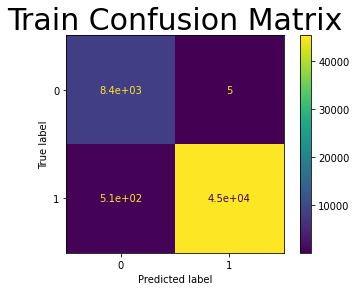

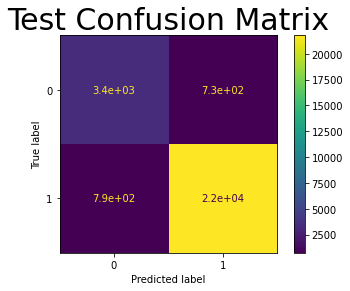

In [79]:
classifier = SGDClassifier(penalty='l1', loss='hinge',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

print_plot_metrics(classifier,x_train_tfidf,x_test_tfidf,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

<b><h1> Feature importance :

In [80]:
feature_imp_value_list = list(zip(coulumn_list_tfidf,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('excellent', 283.5600221758372),
 ('moldy', -279.095732213461),
 ('excellent', 273.77025199392006),
 ('great', 255.6697126456992),
 ('fantastic', 251.39548858240332),
 ('disappointing', -249.67715071094642),
 ('yum', 244.68791543785645),
 ('disappointment', -238.925164874301),
 ('delicious', 232.9810969221404),
 ('terrible', -224.16670769721324),
 ('awesome', 222.3575789396375),
 ('not worth', -221.94922110466314),
 ('not buy', -221.47741985875757),
 ('nasty', -218.8877139088444),
 ('not too', 217.75772120527265),
 ('not recommend', -217.15148830681954),
 ('amaze', 211.69411286547466),
 ('horrible', -210.03044376361078),
 ('perfect', 209.80041218458675),
 ('awful', -205.65297959935995),
 ('disappointing', -204.28535802908266),
 ('best', 197.88670672540374),
 ('favorite', 194.1119491974664),
 ('not very', -193.48881034176205),
 ('tasteless', -192.18957457614002)]

###<b>4.3.2 Using Avg-W2Vec

In [ ]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(penalty='l1', loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.3min finished


Score from Best params :  0.925636763824636
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:01:25.630276


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9861353077816493 │ 0.8897306029777758 │  0.935455734845181 │ 0.8962859145059565 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9847478474784748 │ 0.8871110717135006 │ 0.9333830764567351 │ 0.8930323112059605 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


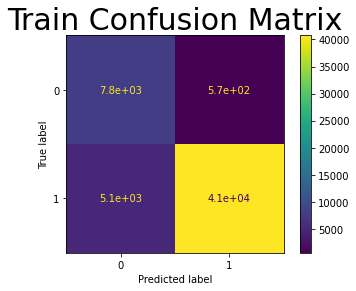

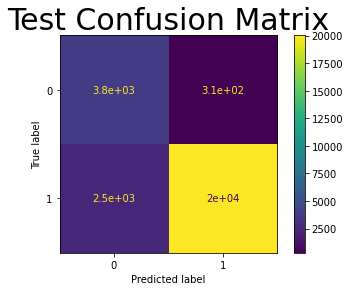

In [ ]:
classifier = SGDClassifier(penalty='l2', loss='hinge',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

print_plot_metrics(classifier,x_train_avg_w2v,x_test_avg_w2v,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

##<b>4.4 RandomForest

###<b>4.4.1 Using Avg-W2Vec

In [ ]:
start = datetime.now()

n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [2,5,10,15,20,30]
max_samples = [0.1,0.2,0.3]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_features = ['sqrt','log2']

random_grid = {
    'n_estimators':n_estimators,
    'max_depth' : max_depth,
    'max_samples' : max_samples,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

classifier = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

randCV = RandomizedSearchCV(classifier, param_distributions = random_grid, n_iter = 100, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_avg_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.3s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 

Score from Best params :  0.9418886303918598
Best params found :  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 15}
Time taken to run this cell : 1:12:05.469656


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9574413971429783 │ 0.9862026808715015 │ 0.9716092399019228 │ 0.9513148674067791 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9131711756432531 │ 0.9784150341281801 │ 0.9446679219445394 │ 0.9031787038077053 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


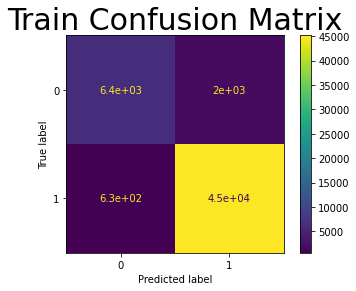

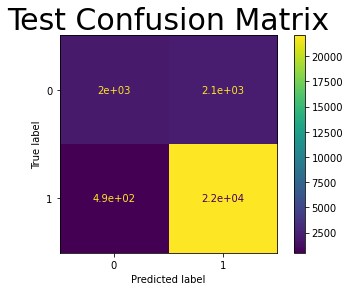

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced',n_estimators= 200, min_samples_split= 5, min_samples_leaf = 4, max_samples = 0.3, max_features = 'sqrt', max_depth = 15,n_jobs=-1)
classifier.fit(x_train_avg_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_avg_w2v)
Y_predicted_test = classifier.predict(x_test_avg_w2v)

print_plot_metrics(classifier,x_train_avg_w2v,x_test_avg_w2v,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

###<b>4.4.2 TFIDF - W2Vec

In [ ]:
start = datetime.now()

n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [2,5,10,15,20,30]
max_samples = [0.1,0.2,0.3]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
max_features = ['sqrt','log2']

random_grid = {
    'n_estimators':n_estimators,
    'max_depth' : max_depth,
    'max_samples' : max_samples,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'max_features' : max_features
}

classifier = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

randCV = RandomizedSearchCV(classifier, param_distributions = random_grid, n_iter = 50, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf_w2v, Y_train)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 37

Score from Best params :  0.937367950943039
Best params found :  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.3, 'max_features': 'sqrt', 'max_depth': 15}
Time taken to run this cell : 0:41:11.189401


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9367582406241615 │ 0.9908090643147186 │ 0.9630258341732534 │ 0.9357319367093276 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.8982050452781372 │ 0.9847531247229856 │ 0.9394900418622352 │ 0.8928451083904302 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


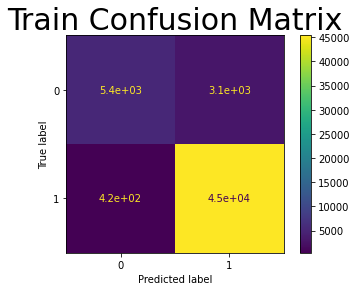

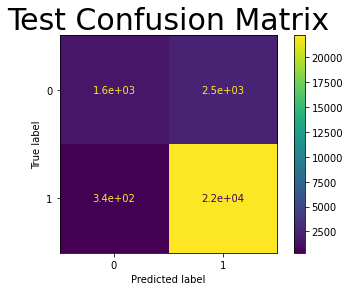

In [ ]:
classifier = RandomForestClassifier(class_weight='balanced',n_estimators= 100, min_samples_split= 5, min_samples_leaf = 4, max_samples = 0.3, max_features = 'sqrt', max_depth = 15,n_jobs=-1)
classifier.fit(x_train_tfidf_w2v,Y_train)

Y_predicted_train = classifier.predict(x_train_tfidf_w2v)
Y_predicted_test = classifier.predict(x_test_tfidf_w2v)

print_plot_metrics(classifier,x_train_tfidf_w2v,x_test_tfidf_w2v,Y_train,Y_predicted_train,Y_test,Y_predicted_test)

##<b>4.5 Using SMOTE to balance negative class

<h2> We will try to balance the negative class and see how Logistic-Regression and SVM behave

In [83]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(X_train_sm.shape), len(y_train_sm)
    return X_train_sm, y_train_sm

In [84]:
x_train_bow , Y_train_smote =  upsample_SMOTE(x_train_bow,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(91612, 8504)


In [85]:
x_test_bow , Y_test_smote =  upsample_SMOTE(x_test_bow,Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(45124, 8504)


In [86]:
x_train_tfidf , Y_train_smote =  upsample_SMOTE(x_train_tfidf,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(91612, 8504)


In [87]:
x_test_tfidf , Y_test_smote =  upsample_SMOTE(x_test_tfidf,Y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(45124, 8504)


<b><h3>4.5.1 BOW with SVM

In [89]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(penalty='l1', loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train_smote)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   28.7s finished


Score from Best params :  0.9697602334794836
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:00:29.791043


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9926687508255911 │ 0.9843470287735231 │ 0.9884903757618275 │ 0.9885386193948391 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.8965987519113939 │ 0.9615725556245014 │ 0.9279496995230864 │ 0.9253390656856662 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


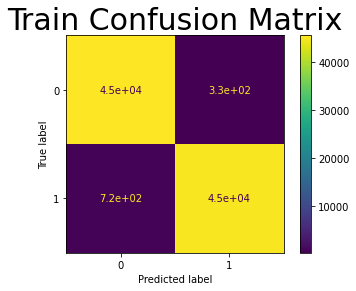

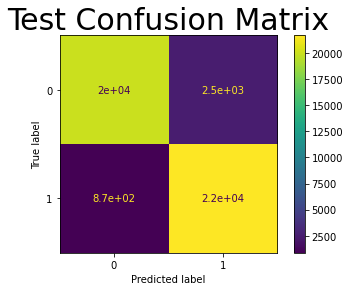

In [90]:
classifier = SGDClassifier(penalty='l2', loss='hinge',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train_smote)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

print_plot_metrics(classifier,x_train_bow,x_test_bow,Y_train_smote,Y_predicted_train,Y_test_smote,Y_predicted_test)

<b><h1> Feature importance :

In [91]:
feature_imp_value_list = list(zip(coulumn_list_bow,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('not worth', -1.597753457076511),
 ('not bad', 1.3122944844802011),
 ('not recommend', -1.2873184797626014),
 ('awesome', 1.2830980847097346),
 ('disappointment', -1.1968206717626475),
 ('terrible', -1.1243765865413675),
 ('disappointed', -1.1200802528722063),
 ('not buy', -1.0981559994777317),
 ('indicate', -1.0935325133516725),
 ('not disappoint', 1.0847592039864136),
 ('excellent', 1.0817629230118402),
 ('disappointing', -1.081584555475767),
 ('ruin', -1.0688906778733944),
 ('not overpower', 1.058124854332755),
 ('definitely not', -1.0473118014183505),
 ('tasteless', -1.0280140496199854),
 ('not very', -0.9918802245515391),
 ('not bad', 0.9678635098383269),
 ('not order', -0.9673605659288909),
 ('skip', -0.9564291738248991),
 ('buy more', 0.9260402185519854),
 ('organic food', -0.9250202740019684),
 ('not disappointed', 0.9145139224539777),
 ('ruin', -0.905285101909037),
 ('not bitter', 0.8956537579428814)]

<b><h3>4.5.2 TFIDF with SVM

In [92]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='hinge', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train_smote)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   15.4s finished


Score from Best params :  0.965172740084535
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:25.449033


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9907998251748251 │  0.989804829061695 │ 0.9903020771902233 │ 0.9903069466882067 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.8742363344051447 │ 0.9640546050882014 │ 0.9169512246532608 │ 0.9126850456519812 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


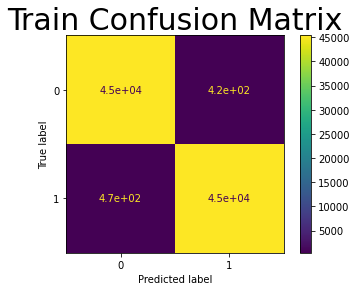

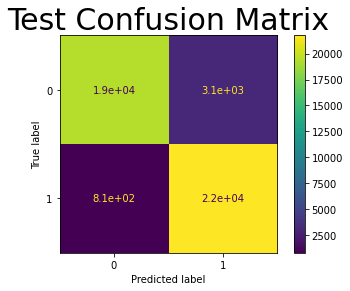

In [96]:
classifier = SGDClassifier(penalty='l1', loss='hinge',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train_smote)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

print_plot_metrics(classifier,x_train_tfidf,x_test_tfidf,Y_train_smote,Y_predicted_train,Y_test_smote,Y_predicted_test)

<b><h1> Feature importance :

In [97]:
feature_imp_value_list = list(zip(coulumn_list_tfidf,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('excellent', 201.24461758944258),
 ('awesome', 195.460168109868),
 ('not recommend', -186.68505490919824),
 ('disappointment', -174.9670633173479),
 ('excellent', 173.71604197865514),
 ('fantastic', 167.75288401933526),
 ('great', 163.40656419963415),
 ('yum', 147.80741683616952),
 ('disappointing', -145.45452498829994),
 ('not worth', -144.52230364001218),
 ('horrible', -142.8276740105852),
 ('awful', -140.81741255458073),
 ('nasty', -139.89613907821203),
 ('best', 138.9022260924466),
 ('delicious', 138.8363505428291),
 ('awful', -138.60857163570878),
 ('not bad', 138.0733542726037),
 ('not too', 137.80752110579135),
 ('ruin', -136.18114075832003),
 ('favorite', 134.53354060555824),
 ('fun', 132.87454762116218),
 ('not very', -130.9872606135177),
 ('unfortunately', -130.41409973785272),
 ('not buy', -130.0254981634655),
 ('amaze', 128.08228428996173)]

<b><h3>4.5.3 BOW with Logistic Regression

In [98]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_bow, Y_train_smote)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   33.3s finished


Score from Best params :  0.9656423551121041
Best params found :  {'penalty': 'l2', 'alpha': 0.0001}
Time taken to run this cell : 0:00:34.303895


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │  0.990999441652708 │ 0.9686940575470462 │ 0.9797198087899229 │ 0.9799480417412566 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.9309639812075866 │ 0.9485417959400763 │ 0.9396706915477497 │ 0.9391011435156458 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


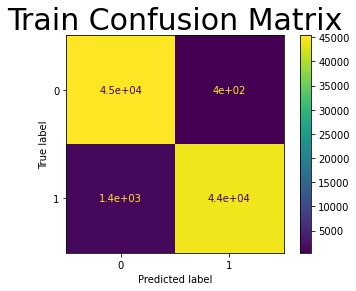

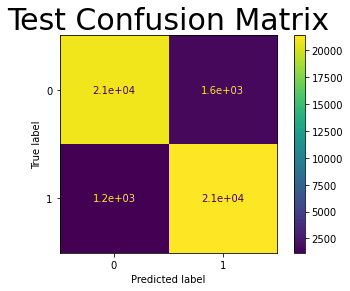

In [99]:
classifier = SGDClassifier(penalty='l2', loss='log',alpha=0.0001, random_state=42,class_weight='balanced')
classifier.fit(x_train_bow,Y_train_smote)

Y_predicted_train = classifier.predict(x_train_bow)
Y_predicted_test = classifier.predict(x_test_bow)

print_plot_metrics(classifier,x_train_bow,x_test_bow,Y_train_smote,Y_predicted_train,Y_test_smote,Y_predicted_test)

<b><h1> Feature importance :

In [100]:
feature_imp_value_list = list(zip(coulumn_list_bow,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('not worth', -2.0894290570175627),
 ('not bad', 1.8837128898824402),
 ('not buy', -1.7385552985432196),
 ('not recommend', -1.6745691989474911),
 ('awesome', 1.6739470955147144),
 ('excellent', 1.6425687422074942),
 ('disappointment', -1.5862082021646402),
 ('indicate', -1.5802438738189792),
 ('terrible', -1.5541143647979796),
 ('disappointed', -1.549766256942924),
 ('not bad', 1.485875155644519),
 ('disappointing', -1.4820643494352126),
 ('not very', -1.3322071501152466),
 ('ruin', -1.2632408734130411),
 ('perfect', 1.2263780534437108),
 ('excellent', 1.2259972838626114),
 ('amaze', 1.2177567690552564),
 ('yum', 1.1706574814825739),
 ('unfortunately', -1.1636526024560732),
 ('not disappoint', 1.1535885555326766),
 ('not good', -1.1525093729291274),
 ('delicious', 1.1517650700623623),
 ('not best', -1.1468231349502738),
 ('best', 1.1386911354669167),
 ('not order', -1.1340213332594113)]

<b><h3>4.5.4 TFIDF with Logistic Regression

In [101]:
start = datetime.now()

alpha = [10 ** x for x in range(-6, 1)]
regularizer = ['l1','l2']

classifier = SGDClassifier(loss='log', random_state=42,class_weight='balanced')

grid_values = {'alpha':alpha,'penalty':regularizer}

randCV = RandomizedSearchCV(classifier, param_distributions = grid_values, n_iter = 6, cv = 3,scoring = 'f1',n_jobs=-1,verbose
=10, random_state=42)

randCV.fit(x_train_tfidf, Y_train_smote)

print("Score from Best params : " ,randCV.best_score_)
print("Best params found : ", randCV.best_params_)
print("Time taken to run this cell :", datetime.now() - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   15.4s finished


Score from Best params :  0.9634782213119027
Best params found :  {'penalty': 'l1', 'alpha': 1e-06}
Time taken to run this cell : 0:00:27.422385


┌─────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ dataset │ Precision          │ Recall             │ F1_Score           │ Accuracy           │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Train   │ 0.9868616324749018 │ 0.9871632537222198 │ 0.9870124200554428 │  0.987010435314151 │
├─────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Test    │ 0.8763913534441039 │ 0.9631681588511657 │ 0.9177330123738333 │ 0.9136601365127205 │
└─────────┴────────────────────┴────────────────────┴────────────────────┴────────────────────┘


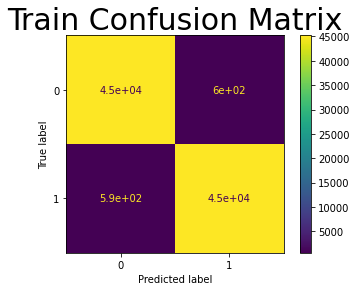

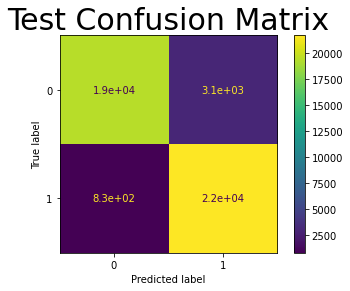

In [104]:
classifier = SGDClassifier(penalty='l1', loss='log',alpha=0.000001, random_state=42,class_weight='balanced')
classifier.fit(x_train_tfidf,Y_train_smote)

Y_predicted_train = classifier.predict(x_train_tfidf)
Y_predicted_test = classifier.predict(x_test_tfidf)

print_plot_metrics(classifier,x_train_tfidf,x_test_tfidf,Y_train_smote,Y_predicted_train,Y_test_smote,Y_predicted_test)

<b><h1> Feature importance :

In [105]:
feature_imp_value_list = list(zip(coulumn_list_tfidf,list(classifier.coef_.flatten())))
feature_imp_value_list.sort(key=lambda x:abs(x[1]),reverse=True)
feature_imp_value_list[0:25]

[('excellent', 204.20973447210469),
 ('not recommend', -188.8746856062447),
 ('awesome', 170.90249277047468),
 ('excellent', 165.34546583740936),
 ('disappointment', -163.96943614785204),
 ('yum', 162.46683957340886),
 ('great', 161.21699899185845),
 ('delicious', 155.2520245147925),
 ('disappointing', -154.2228587165247),
 ('horrible', -147.76715843253044),
 ('nasty', -145.67577251152727),
 ('fantastic', 141.4362314288379),
 ('not worth', -141.13106028374511),
 ('not bad', 140.06119580144966),
 ('awful', -136.2099770042693),
 ('yuck', -136.09047316319928),
 ('not buy', -135.15094963046968),
 ('ruin', -134.1317509794048),
 ('easy', 133.32668129352137),
 ('not very', -131.16686423456704),
 ('amaze', 131.029004542609),
 ('best', 130.2406669569917),
 ('favorite', 129.45328519156192),
 ('weak', -127.17829161222325),
 ('unfortunately', -126.41224309075538)]

<b><h1>5. SUMMARY :

In [106]:
data = [['Model','Vectorizer','dataset','Precision','Recall','F1_Score','Accuracy'],
  ['Log Reg','BOW','Train',0.999,0.994,0.997,0.994],
  ['','','Test',0.962,0.961,0.961,0.935],
  [],
  ['Log Reg','TFIDF','Train',0.999,0.984,0.992,0.986],
  ['','','Test',0.967, 0.963, 0.965, 0.942],
  [],
  ['Log Reg','AVG-W2V','Train',0.987, 0.869, 0.924, 0.88],
  ['','','Test',0.987, 0.868, 0.924, 0.879],
  [],
  ['SVM','BOW','Train',0.999, 0.993, 0.996, 0.994],
  ['','','Test',0.962, 0.961, 0.961, 0.935],
  [],
  ['SVM','TFIDF','Train',0.999, 0.988, 0.994, 0.99],
  ['','','Test',0.967, 0.965, 0.966, 0.943],
  [],
  ['SVM','AVG-W2V','Train',0.986, 0.889, 0.935, 0.896],
  ['','','Test',0.984, 0.887, 0.933, 0.893],
  [],
  ['RF','AVG-W2V','Train',0.957, 0.986, 0.971, 0.951],
  ['','','Test',0.913, 0.978, 0.944, 0.903],
  [],
  ['RF','TFIDF-W2V','Train',0.936, 0.99, 0.963, 0.935],
  ['','','Test',0.898, 0.984, 0.939, 0.892],
  [],
  ['SVM-SMOTE','BOW','Train',0.992, 0.984, 0.988, 0.988],
  ['','','Test',0.896, 0.961, 0.927, 0.925],
  [],
  ['SVM-SMOTE','TFIDF','Train',0.99, 0.989, 0.99, 0.99],
  ['','','Test',0.874, 0.964, 0.916, 0.912],
  [],
  ['Log-Reg-SMOTE','BOW','Train',0.99, 0.968, 0.979, 0.979],
  ['','','Test',0.93, 0.948, 0.939, 0.939],
  [],
  ['Log-Reg-SMOTE','TFIDF','Train', 0.986, 0.987, 0.987, 0.987],
  ['','','Test',0.876, 0.963, 0.917, 0.913],
  ]
print(tabletext.to_text(data))

┌───────────────┬────────────┬─────────┬───────────┬────────┬──────────┬──────────┐
│ Model         │ Vectorizer │ dataset │ Precision │ Recall │ F1_Score │ Accuracy │
├───────────────┼────────────┼─────────┼───────────┼────────┼──────────┼──────────┤
│ Log Reg       │ BOW        │ Train   │     0.999 │  0.994 │    0.997 │    0.994 │
├───────────────┼────────────┼─────────┼───────────┼────────┼──────────┼──────────┤
│               │            │ Test    │     0.962 │  0.961 │    0.961 │    0.935 │
├───────────────┼────────────┼─────────┼───────────┼────────┼──────────┼──────────┤
│               │            │         │           │        │          │          │
├───────────────┼────────────┼─────────┼───────────┼────────┼──────────┼──────────┤
│ Log Reg       │ TFIDF      │ Train   │     0.999 │  0.984 │    0.992 │    0.986 │
├───────────────┼────────────┼─────────┼───────────┼────────┼──────────┼──────────┤
│               │            │ Test    │     0.967 │  0.963 │    0.965 │    

<h1> We can see from the table that <b>Logistic Regression With TFDF</b> looks least overfitted model with best accuracy